# Predicción multimodal del precio de monitores

Este notebook replica la CNN original basada en ResNet-18 y la complementa con un módulo semántico que resume la descripción del producto mediante *embeddings*. El pipeline completo es:

1. Limpieza del dataset y descarga (o reutilización) de las imágenes.
2. Normalización de las descripciones (minúsculas) y extracción de embeddings multilingües para cada una.
3. Construcción de un dataset multimodal (imagen + texto) y entrenamiento en PyTorch de un modelo que fusiona ambas representaciones para predecir el `precio_original`.
4. Evaluación cuantitativa/visual y helper de inferencia para nuevos productos.


In [1]:
# Si trabajas en un entorno limpio descomenta la siguiente línea para instalar dependencias.
# !pip install -q pandas certifi pyarrow sentence-transformers torch torchvision torchaudio scikit-learn seaborn opencv-python pillow requests


In [2]:
import warnings
import urllib.request
from pathlib import Path
import os
import ssl
import certifi
import time
import requests

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from PIL import Image
from sentence_transformers import SentenceTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

os.environ['SSL_CERT_FILE'] = certifi.where()
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()
ssl._create_default_https_context = ssl.create_default_context
warnings.filterwarnings('ignore')

def get_device():
    if torch.cuda.is_available():
        return 'cuda'
    if getattr(torch.backends, 'mps', None) and torch.backends.mps.is_available():
        return 'mps'
    return 'cpu'

DEVICE = get_device()
print(f"Usando dispositivo: {DEVICE}")

torch.manual_seed(42)
np.random.seed(42)


Usando dispositivo: mps


In [3]:
# ======================= Carga y limpieza del dataset =======================
DATA_PATH = Path('productos_falabella.parquet')
assert DATA_PATH.exists(), f'No se encontró {DATA_PATH}'

df = pd.read_parquet(DATA_PATH)
print(f'Filas originales: {len(df):,}')

# Limpieza de precios

def clean_price(value: str) -> str:
    value = str(value)
    value = value.replace('S/.', '').replace('S/', '').replace('USD', '').replace('$', '')
    value = value.replace(' ', '').replace(' ', '')
    return value.replace(',', '')

df['precio_original'] = df['precio_original'].apply(clean_price)
df['precio_original'] = pd.to_numeric(df['precio_original'], errors='coerce')

# Filtramos registros sin datos clave
required_cols = ['precio_original', 'imagen', 'descripcion']
df = df.dropna(subset=required_cols).reset_index(drop=True)
print(f'Filas utilizables tras limpieza básica: {len(df):,}')
df.head()


Filas originales: 1,472
Filas utilizables tras limpieza básica: 1,472


,descripcion,precio_cmr,precio_oferta,precio_original,imagen
0,"Monitor plano gaming TE-2753G, 27"" 2K QHD IPS,...",None,749,1259.0,https://media.falabella.com.pe/falabellaPE/140...
1,Monitor Gamer 24 Pulg Te-2415s Fhd 120hz Vesa,None,319,480.0,https://media.falabella.com.pe/falabellaPE/140...
2,"Monitor 27"" Resolución FHD CURVO 100 Hz",None,398,790.0,https://media.falabella.com.pe/falabellaPE/127...
3,"Monitor 24"" TE-2415S 23.8 IPS 120HZ 1MS HDMI P...",None,282.80,599.0,https://media.falabella.com.pe/falabellaPE/136...
4,Monitor TE-2402S 238 CURVO FHD 100HZ 1MS HDMI ...,None,295.99,399.0,https://media.falabella.com.pe/falabellaPE/141...


In [7]:
# ======================= Descarga / cacheo de imágenes =======================
IMAGES_DIR = Path('imagenes')
IMAGES_DIR.mkdir(exist_ok=True)

headers = {
    "User-Agent": ("Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                   "AppleWebKit/537.36 (KHTML, like Gecko) "
                   "Chrome/120.0.0.0 Safari/537.36"),
    "Accept": "image/avif,image/webp,image/apng,image/*,*/*;q=0.8",
    "Accept-Language": "es-ES,es;q=0.9,en;q=0.8",
    "Connection": "keep-alive",
    # Falabella suele exigir referer del mismo dominio:
    "Referer": "https://www.falabella.com.pe/",
}
session = requests.Session()
session.headers.update(headers)
session.verify = certifi.where()


def download_image(url: str, dest: Path, timeout: int = 30):
    resp = session.get(url, timeout=timeout)
    if resp.status_code == 403:
        raise ValueError('HTTP 403 - Falabella bloqueó la descarga (verifica headers o espera un momento).')
    resp.raise_for_status()
    data = np.asarray(bytearray(resp.content), dtype=np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError('cv2 no pudo decodificar la imagen')
    cv2.imwrite(str(dest), image)


records = []
for idx, row in df.iterrows():
    dest = IMAGES_DIR / f"{idx}.png"
    if not dest.exists():
        try:
            download_image(row['imagen'], dest)
            time.sleep(0.2)  # Evita bloquear al servidor
        except Exception as err:
            print(f"⚠️  Saltando índice {idx} por error al descargar: {err}")
            continue
    row_dict = row.to_dict()
    row_dict['image_path'] = str(dest)
    records.append(row_dict)

if not records:
    raise RuntimeError('No fue posible descargar imágenes válidas')

df = pd.DataFrame(records).reset_index(drop=True)
print(f'Filas finales con imagen local: {len(df):,}')
df[['descripcion', 'image_path']].head()


Filas finales con imagen local: 1,472


,descripcion,image_path
0,"Monitor plano gaming TE-2753G, 27"" 2K QHD IPS,...",imagenes/0.png
1,Monitor Gamer 24 Pulg Te-2415s Fhd 120hz Vesa,imagenes/1.png
2,"Monitor 27"" Resolución FHD CURVO 100 Hz",imagenes/2.png
3,"Monitor 24"" TE-2415S 23.8 IPS 120HZ 1MS HDMI P...",imagenes/3.png
4,Monitor TE-2402S 238 CURVO FHD 100HZ 1MS HDMI ...,imagenes/4.png


In [8]:
# ======================= Limpieza de descripciones =======================
df['descripcion_clean'] = (
    df['descripcion']
    .fillna('')
    .str.lower()
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)

df[['descripcion', 'descripcion_clean']].head()


,descripcion,descripcion_clean
0,"Monitor plano gaming TE-2753G, 27"" 2K QHD IPS,...","monitor plano gaming te-2753g, 27"" 2k qhd ips,..."
1,Monitor Gamer 24 Pulg Te-2415s Fhd 120hz Vesa,monitor gamer 24 pulg te-2415s fhd 120hz vesa
2,"Monitor 27"" Resolución FHD CURVO 100 Hz","monitor 27"" resolución fhd curvo 100 hz"
3,"Monitor 24"" TE-2415S 23.8 IPS 120HZ 1MS HDMI P...","monitor 24"" te-2415s 23.8 ips 120hz 1ms hdmi p..."
4,Monitor TE-2402S 238 CURVO FHD 100HZ 1MS HDMI ...,monitor te-2402s 238 curvo fhd 100hz 1ms hdmi ...


In [9]:
# ======================= Embeddings de texto =======================
st_device = 'cuda' if torch.cuda.is_available() else 'cpu'
text_encoder = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2', device=st_device)
text_embeddings = text_encoder.encode(
    df['descripcion_clean'].tolist(),
    batch_size=64,
    convert_to_numpy=True,
    show_progress_bar=True,
    normalize_embeddings=True,
)
text_embeddings = text_embeddings.astype(np.float32)
embedding_dim = text_embeddings.shape[1]
print(f'Dimensión de embedding: {embedding_dim}')


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/23 [00:00<?, ?it/s]

Dimensión de embedding: 384


In [10]:
# ======================= Split train/valid =======================
image_paths = np.array(df['image_path'].tolist())
targets = df['precio_original'].to_numpy(dtype=np.float32)
indices = np.arange(len(df))

train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_data = {
    'paths': image_paths[train_idx].tolist(),
    'text': text_embeddings[train_idx],
    'targets': targets[train_idx],
}
val_data = {
    'paths': image_paths[val_idx].tolist(),
    'text': text_embeddings[val_idx],
    'targets': targets[val_idx],
}

len(train_data['paths']), len(val_data['paths'])


(1177, 295)

In [12]:
# ======================= Dataset + DataLoaders =======================
class MonitorDataset(Dataset):
    def __init__(self, image_paths, text_features, targets, transform=None):
        self.image_paths = image_paths
        self.text_features = torch.as_tensor(text_features, dtype=torch.float32)
        self.targets = torch.as_tensor(targets, dtype=torch.float32).view(-1, 1)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        text_feat = self.text_features[idx]
        target = self.targets[idx]
        return image, text_feat, target

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

BATCH_SIZE = 32
pin_memory = DEVICE == 'cuda'

train_ds = MonitorDataset(train_data['paths'], train_data['text'], train_data['targets'], transform=train_tfms)
val_ds = MonitorDataset(val_data['paths'], val_data['text'], val_data['targets'], transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=pin_memory)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=pin_memory)

len(train_ds), len(val_ds)


(1177, 295)

In [13]:
# ======================= Modelo multimodal =======================
class MultimodalRegressor(nn.Module):
    def __init__(self, text_dim, dropout=0.3, text_hidden=256, fusion_hidden=256):
        super().__init__()
        self.image_backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        image_feat_dim = self.image_backbone.fc.in_features
        self.image_backbone.fc = nn.Identity()

        self.text_mlp = nn.Sequential(
            nn.Linear(text_dim, text_hidden),
            nn.LayerNorm(text_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.regressor = nn.Sequential(
            nn.Linear(image_feat_dim + text_hidden, fusion_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_hidden, 1),
        )

    def forward(self, images, text_feat):
        img_feat = self.image_backbone(images)
        txt_feat = self.text_mlp(text_feat)
        fused = torch.cat([img_feat, txt_feat], dim=1)
        return self.regressor(fused)

model = MultimodalRegressor(text_dim=embedding_dim).to(DEVICE)
model


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/alarcon/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 62.8MB/s]


MultimodalRegressor(
  (image_backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [14]:
# ======================= Entrenamiento =======================
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, text_feat, targets in dataloader:
        images = images.to(DEVICE)
        text_feat = text_feat.to(DEVICE)
        targets = targets.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)
        preds = model(images, text_feat)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    return running_loss / len(dataloader.dataset)


def eval_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    preds_list, targets_list = [], []
    with torch.inference_mode():
        for images, text_feat, targets in dataloader:
            images = images.to(DEVICE)
            text_feat = text_feat.to(DEVICE)
            targets = targets.to(DEVICE)

            preds = model(images, text_feat)
            loss = criterion(preds, targets)
            running_loss += loss.item() * images.size(0)

            preds_list.append(preds.cpu().numpy())
            targets_list.append(targets.cpu().numpy())
    preds = np.concatenate(preds_list).ravel()
    targets = np.concatenate(targets_list).ravel()
    return running_loss / len(dataloader.dataset), preds, targets


def fit(model, train_loader, val_loader, epochs=12, lr=3e-4, weight_decay=1e-4):
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, _, _ = eval_epoch(model, val_loader, criterion)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        print(f"[{epoch:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")
    return history

history = fit(model, train_loader, val_loader)


[01] train_loss=731.2874 | val_loss=683.8077
[02] train_loss=652.8218 | val_loss=574.9773
[03] train_loss=506.0235 | val_loss=357.0432
[04] train_loss=304.9925 | val_loss=186.7509
[05] train_loss=155.5844 | val_loss=70.2468
[06] train_loss=87.2440 | val_loss=42.6245
[07] train_loss=83.7234 | val_loss=58.4634
[08] train_loss=80.1909 | val_loss=29.7377
[09] train_loss=76.5611 | val_loss=39.8180
[10] train_loss=64.7786 | val_loss=41.3280
[11] train_loss=65.7113 | val_loss=27.7474
[12] train_loss=64.3870 | val_loss=22.2589


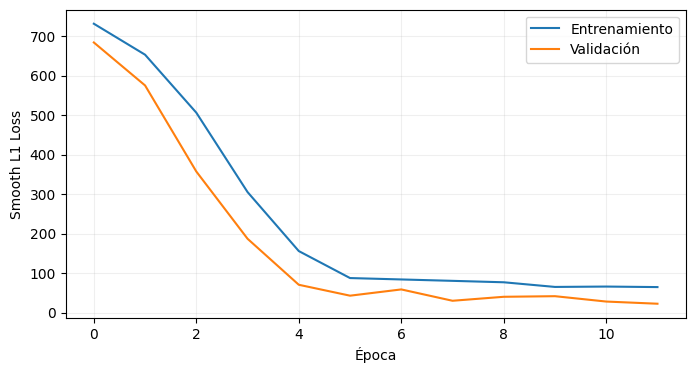

In [15]:
# ======================= Curvas de entrenamiento =======================
plt.figure(figsize=(8, 4))
plt.plot(history['train_loss'], label='Entrenamiento')
plt.plot(history['val_loss'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Smooth L1 Loss')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


MAE : 22.76
R^2 : 0.995


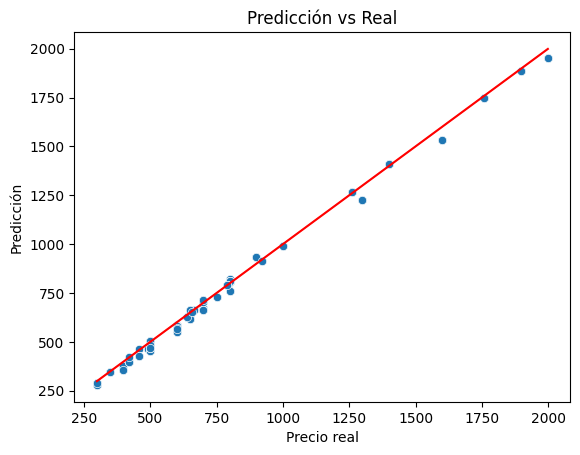

In [18]:
# ======================= Métricas finales =======================
criterion = nn.SmoothL1Loss()
val_loss, val_preds, val_targets = eval_epoch(model, val_loader, criterion)
mae = mean_absolute_error(val_targets, val_preds)
#rmse = mean_squared_error(val_targets, val_preds, squared=False)
r2 = r2_score(val_targets, val_preds)

print(f"MAE : {mae:,.2f}")
#print(f"RMSE: {rmse:,.2f}")
print(f"R^2 : {r2:.3f}")

sns.scatterplot(x=val_targets, y=val_preds)
sns.lineplot(x=val_targets, y=val_targets, color='red')
plt.xlabel('Precio real')
plt.ylabel('Predicción')
plt.title('Predicción vs Real')
plt.show()


In [19]:
# ======================= Helper de inferencia =======================
def predict_price(image_path: str, description: str, model, text_encoder, image_transform, device=DEVICE):
    model.eval()
    clean_desc = ' '.join(description.lower().split())
    text_vec = text_encoder.encode([clean_desc], convert_to_numpy=True, normalize_embeddings=True)
    text_tensor = torch.tensor(text_vec, dtype=torch.float32).to(device)

    image = Image.open(image_path).convert('RGB')
    image_tensor = image_transform(image).unsqueeze(0).to(device)

    with torch.inference_mode():
        pred = model(image_tensor, text_tensor)
    return pred.squeeze().item()

sample = df.sample(1, random_state=0).iloc[0]
sample_pred = predict_price(
    image_path=sample['image_path'],
    description=sample['descripcion'],
    model=model,
    text_encoder=text_encoder,
    image_transform=val_tfms,
)

print('Descripción:', sample['descripcion'])
print(f"Precio real: {sample['precio_original']:.2f} | Predicción: {sample_pred:.2f}")


Descripción: Monitor Gamer A24I 24 Full HD 5MS 100HZ IPS
Precio real: 499.00 | Predicción: 470.54


In [24]:
description = "Monitor LG 24MS500-B 24 Full HD 1080p 100Hz 5ms GtG AMD FreeSync IPS"
img_path = "/Users/alarcon/Downloads/w=1500,h=1500,fit=pad (1).webp"

predict_price(
    img_path,
    description,
    model,
    text_encoder,
    val_tfms
)

633.5213623046875